In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary # type: ignore

In [2]:
# Define a Convolutional Neural Network.


class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)  # Output: (N, 16, 34, 34)
        self.pool = nn.MaxPool2d(2, 2)  # After pool: (N, 16, 17, 17)
        self.conv2 = nn.Conv2d(16, 16, 3)  # Output: (N, 16, 15, 15)
        # After pool: (N, 16, 7, 7)
        self.fc1 = nn.Linear(16 * 7 * 7, 128)  # (784, 120)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

In [3]:
# Move the net to GPU, if available.
device = "cuda" if torch.cuda.is_available() else "cpu"
net = net.to(device)

In [4]:
# Define a Loss function and optimizer.
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
# Load dataset.
fname = "data/LSWMD_dataset.pkl"  # If it doesn't exists run 'LSWMD-explore.ipynb'.
df = pd.read_pickle(fname)

X = np.array([x for x in df["X"].to_numpy()])
Y = df["Y"].to_numpy(dtype=np.uint8)

# Split data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Convert numpy data to pytorch tensors.
train_tensor_data = torch.from_numpy(X_train).unsqueeze(1).float()  # Add channel of 1.
train_tensor_labels = torch.from_numpy(y_train).long()

test_tensor_data = torch.from_numpy(X_test).unsqueeze(1).float()  # Add channel of 1.
test_tensor_labels = torch.from_numpy(y_test).long()

In [6]:
# Load tensor data.
train_dataset = TensorDataset(train_tensor_data, train_tensor_labels)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(test_tensor_data, test_tensor_labels)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [7]:
summary(net, train_tensor_data.shape[1:])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 34, 34]             160
         MaxPool2d-2           [-1, 16, 17, 17]               0
            Conv2d-3           [-1, 16, 15, 15]           2,320
         MaxPool2d-4             [-1, 16, 7, 7]               0
            Linear-5                  [-1, 128]         100,480
            Linear-6                    [-1, 2]             258
Total params: 103,218
Trainable params: 103,218
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.39
Estimated Total Size (MB): 0.61
----------------------------------------------------------------


In [8]:
# Train CNN model.
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    for batch_data, batch_labels in train_dataloader:
        # Zero gradients.
        optimizer.zero_grad()

        # Move data to gpu, if available.
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # forward + backward + optimize.
        outputs = net(batch_data)
        loss_out = loss(outputs, batch_labels)
        loss_out.backward()
        optimizer.step()

    losses.append(loss_out.item())
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses[-1]:.4f}")

print("Finished Training")

KeyboardInterrupt: 

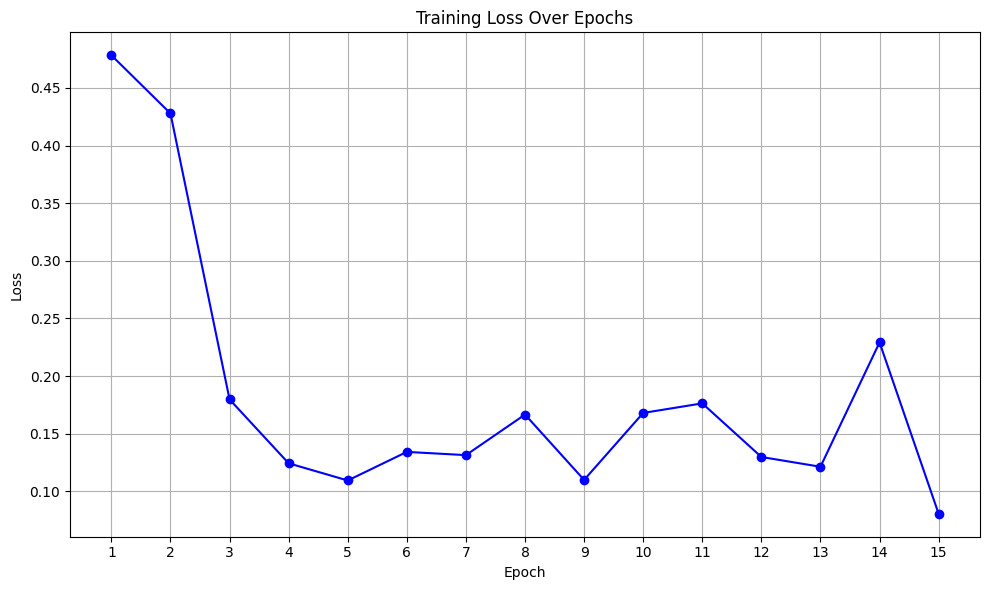

In [ ]:
epochs = list(range(1, 16))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Helper function for evaluation.


def evaluate(
    model: nn.Module,
    criterion: nn.Module,
    minibatcher: DataLoader,
    device: str,
) -> float:
    R"""
    Evaluate.
    """
    model.eval()

    buf_total = []
    buf_metric = []
    for inputs, targets in minibatcher:
        inputs = inputs.to(device)
        targets = targets.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            total = len(targets)
            metric = criterion.forward(outputs, targets).item()
        buf_total.append(total)
        buf_metric.append(metric * total)

    return float(sum(buf_metric)) / float(sum(buf_total))


class Accuracy(nn.Module):
    R"""
    Accuracy module.
    """

    def forward(
        self,
        output: torch.Tensor,
        target: torch.Tensor,
        /,
    ) -> torch.Tensor:
        R"""
        Forward.
        """
        return torch.sum(torch.argmax(output, dim=1) == target) / len(target)

In [ ]:
# Evaluate model.
metric = Accuracy()

ce_train = evaluate(net, loss, train_dataloader, device=device)
acc_train = evaluate(net, metric, train_dataloader, device=device)
acc_test = evaluate(net, metric, test_dataloader, device=device)

print("Train Loss: {:.6f}".format(ce_train))
print(" Train Acc: {:.6f}".format(acc_train))
print("  Test Acc: {:.6f}".format(acc_test))

Train Loss: 0.109068
 Train Acc: 0.961272
  Test Acc: 0.957298


In [ ]:
# Original data
# Train Loss: 0.063256
#  Train Acc: 0.978910
#   Test Acc: 0.969500

# With extra fault samples.
# Train Loss: 0.109068
#  Train Acc: 0.961272
#   Test Acc: 0.957298

In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
)

# Predict probabilties.
net.eval()
pred_test = net(X_test)

# Compute loss.
loss_out = loss(pred_test, y_test)

# Predict classes.
y_hat_test = np.argmax(pred_test, axis=1)

# Compute evaluation metrics.
precision = precision_score(y_test, y_hat_test)
recall = recall_score(y_test, y_hat_test)
f1 = f1_score(y_test, y_hat_test)
auc = roc_auc_score(y_test, pred_test)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("AUC:", auc)

# Optional: Detailed classification report (includes support, etc.).
print(
    "\nClassification Report:\n", classification_report(y_test, y_hat_test)
)

print(f"Test Loss: {loss_out}")
print(f"Test Accuracy: {np.sum(y_hat_test == y_test) / len(y_test)}")
print(f"Total test images: {X_test.shape[0]}")